In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)


%matplotlib inline
from nuscenes.nuscenes import NuScenes
from util.depth_map_utils import *
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import cv2
from pyquaternion import Quaternion
import time

In [2]:
# load dataset
nusc = NuScenes(version='v1.0-mini', dataroot='../v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
# get the first scene
scene = nusc.scene[0]

# load first sample from scene
sample = nusc.get('sample', scene['first_sample_token'])

# get the picture from camera front
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', sample['data'][sensor])

# Load boxes and image.
data_path, boxes, camera_intrinsic = nusc.explorer.nusc.get_sample_data(cam_front_data['token'])

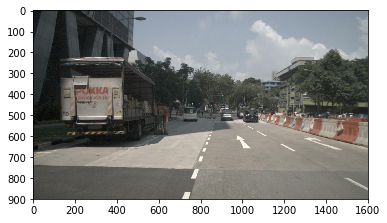

In [4]:
# get and display image
img = np.array(Image.open(data_path))
plt.imshow(img)
plt.show()

In [5]:
calib_sensor = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
translation = calib_sensor['translation']
rotation = calib_sensor['rotation']
                
# camera extrinisc
q = Quaternion(rotation)
R = q.rotation_matrix
T = np.array(translation).reshape(-1, 1)


In [6]:
alphax = np.pi / 2
alphay = np.pi / 2
alphaz = -np.pi / 2

Rx = np.array([
    [1, 0, 0],
    [0, np.cos(alphax), -np.sin(alphax)],
    [0, np.sin(alphax), np.cos(alphax)]
])

Ry = np.array([
    [np.cos(alphay), 0, -np.sin(alphay)],
    [0, 1, 0],
    [np.sin(alphay), 0, np.cos(alphay)]
])

Rz = np.array([
    [np.cos(alphaz), np.sin(alphaz), 0],
    [-np.sin(alphaz), np.cos(alphaz), 0],
    [0, 0, 1],
])

Rot = Rz @ Ry

R = Rot @ R
T = Rot @ T

camera_extrinsic = np.hstack((R, T))

In [7]:
print("X coordindat: %.2f. This should be close to zero\n" % (T[0]))
print("Y coordinate: %.2f. This shoud be negative and close to the car's height\n" % (T[1]))
print("Z coodrinate: %.2f. This should be positive and close to the car's roof length\n" % (T[2]))
print("Rotation matrix should be close to the identity since no rotation")
print(R)

X coordindat: -0.02. This should be close to zero

Y coordinate: -1.51. This shoud be negative and close to the car's height

Z coodrinate: 1.70. This should be positive and close to the car's roof length

Rotation matrix should be close to the identity since no rotation
[[ 9.99983517e-01  8.37115272e-04 -5.68014846e-03]
 [-8.05071338e-04  9.99983763e-01  5.64133364e-03]
 [ 5.68477868e-03 -5.63666773e-03  9.99967955e-01]]


In [8]:
# depth map
sensor = 'LIDAR_TOP'
lidar = nusc.get('sample_data', sample['data'][sensor])
points, coloring, im = nusc.explorer.map_pointcloud_to_image(
    pointsensor_token=lidar['token'],
    camera_token=cam_front_data['token']
)

depth_map = np.zeros((img.shape[0], img.shape[1])).astype(np.float32)
for i, (x, y) in enumerate(zip(points[0], points[1])):
    int_x, int_y = np.floor([x, y]).astype(np.int)
    int_x = np.clip(int_x, 0, depth_map.shape[1] - 1)
    int_y = np.clip(int_y, 0, depth_map.shape[0] - 1)
    depth_map[int_y, int_x] = coloring[i]
    
orig_depth_map = depth_map.copy()

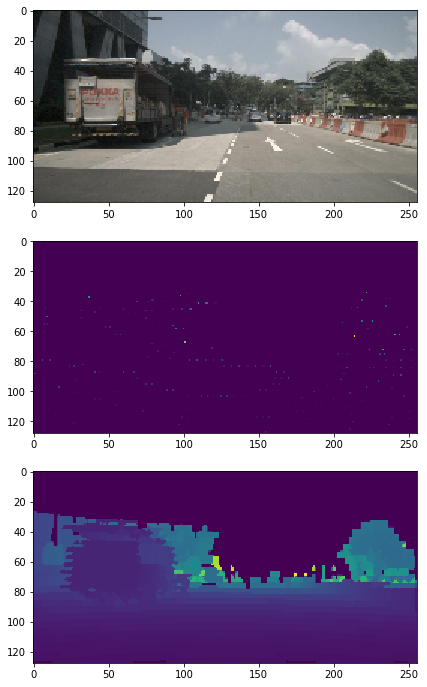

In [9]:
# # Fast fill with Gaussian blur @90Hz (paper result)
# fill_type = 'fast'
# extrapolate = True
# blur_type = 'gaussian'

extrapolate = False
blur_type = 'bilateral'

#if fill_type == 'fast':
depth_map = fill_in_fast(
    depth_map,
    extrapolate=extrapolate, 
    blur_type=blur_type
)
#elif fill_type == 'multiscale':
depth_map, process_dict = fill_in_multiscale(
    depth_map, 
    extrapolate=extrapolate, 
    blur_type=blur_type,
    show_process=False
)


# save original dimensions
orig_height, orig_width, _ = img.shape

# resize image and depth_map
height, width = 128, 256
img = cv2.resize(img, (width, height))
orig_depth_map = cv2.resize(orig_depth_map, (width, height))
depth_map = cv2.resize(depth_map, (width, height))

# update camera intrinsics according to the new size
scale = np.array([
    [width/orig_width, 0, 0],
    [0, height/orig_height, 0],
    [0, 0, 1]
])
camera_intrinsic = scale @ camera_intrinsic

# plot
fig, axs = plt.subplots(3, figsize=(8, 12))
axs[0].imshow(img)
axs[1].imshow(orig_depth_map / orig_depth_map.max())
axs[2].imshow(depth_map / depth_map.max())

### Inverse Warp

In [10]:
from util.inverse_warp import *
import torch

In [11]:
# transform data to torch.tensors
timg = torch.from_numpy(img.transpose((2, 0, 1))).unsqueeze(0).double()
tdepth = torch.from_numpy(depth_map).unsqueeze(0).double()
tpose = torch.tensor([0.5, 0.0, 0.0, 0.0, 0.07, 0.0]).unsqueeze(0).double()
tintrinsic = torch.from_numpy(camera_intrinsic).unsqueeze(0).double()
textrinsic = torch.from_numpy(camera_extrinsic).unsqueeze(0).double()

In [12]:
print("Img shape:", timg.shape)
print("Depth shape:", tdepth.shape)
print("Pose shape:", tpose.shape)
print("Intrinsic shape:", tintrinsic.shape)

Img shape: torch.Size([1, 3, 128, 256])
Depth shape: torch.Size([1, 128, 256])
Pose shape: torch.Size([1, 6])
Intrinsic shape: torch.Size([1, 3, 3])


In [13]:
start = time.time()

projected_img1, valid_points1 = forward_warp(
    img=timg, 
    depth=tdepth, 
    pose=tpose, 
    intrinsics=tintrinsic,
    extrinsics=textrinsic
)

print("Ellapsed: %.2f" % (time.time() - start))

Ellapsed: 22.65


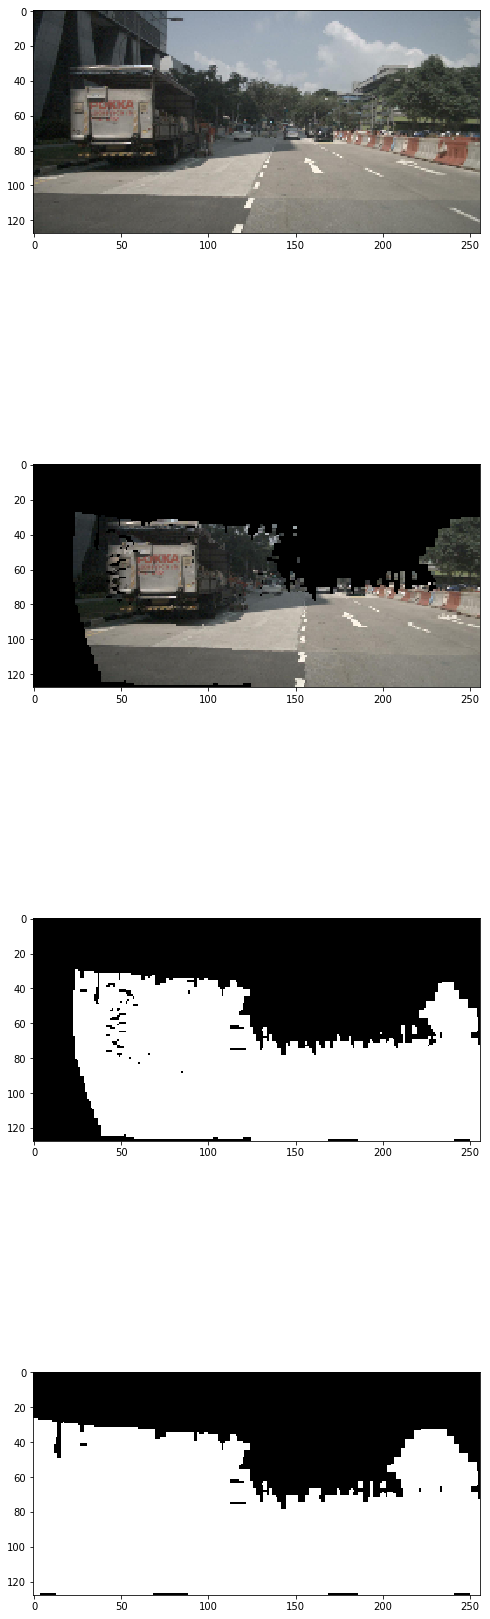

In [14]:
pimg1 = (projected_img1 * valid_points1.double()).squeeze(0).numpy().transpose((1, 2, 0)).astype(int)
vpoints1 = (valid_points1.double()).squeeze(0).numpy() * (depth_map > 0)

fig, axs = plt.subplots(4, figsize=(8, 32))
axs[0].imshow(img)
axs[1].imshow(pimg1)
axs[2].imshow(vpoints1, cmap='gray', vmin=0, vmax=1)
axs[3].imshow(depth_map > 0, cmap='gray', vmin=0, vmax=1)

In [15]:
# # if only translation applied, the difference in norm between
# # the pimg1 and pimg2 should be small
# print("Norm difference: %.2f" % (np.linalg.norm(pimg1 - pimg2)))